In [1]:
import platform
from pathlib import Path

import os
import subprocess
import time

import numpy as np
import scipy
from scipy import optimize
import pandas as pd # I added as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from addict import Dict
import json

# Temporary files for simulation objects
import tempfile
tempfile.tempdir = os.path.join(Path.home())

# IPython
from IPython.core.display import display, HTML, clear_output
display(HTML("<style>.container { width:100% !important; }</style>"))
from IPython.display import Image
from ipywidgets import interact, interactive
import ipywidgets as widgets

import copy

# Previous work

In [2]:
def first_moment(time, absorbance):
    total_num = 0
    total_den = 0
    for element in range(len(time)):
        if element==0:
            pass
        elif absorbance[element] > 0:
            total_num   += absorbance[element]*(time[element] - time[element-1])*time[element]
            total_den   += absorbance[element]*(time[element] - time[element-1])
    return total_num/total_den

In [3]:
# pH 7, 20 mM phosphate

def cond_2_tis(cond):
    tis = (0.0229207306*(cond**2) + 9.3999636424*cond + 21.2424910935)
    return tis

def nacl_2_is(nacl):
    """Convert NaCl [mM] to IS [mM]"""
    return 1e3*(1.019*nacl*1e-3 + 0.041)

def is_2_nacl(tis):
    """Convert IS [mM] to  NaCl [mM]"""
    return 1e3*(tis*1e-3 - 0.041)/1.019

In [4]:
# Parameter correlations, pH 7

def my_fit_function_keq(tis, a, b, c):
    return c*np.exp(a*(tis)**b)

def my_fit_function_keq_2(tis, a, b):
    return a*tis**b

def my_fit_function_ds(keq, a, b):
    return np.log(a*keq**b)

def get_fit_param_inputs():
    data_file    = pd.ExcelFile('aex_pH_7_all_data.xlsx') # Change here
    protein_list = ['adh', 'blg', 'cat', 'ova'] 
    return data_file, protein_list

def get_correlation(resin):
    data_file, protein_list = get_fit_param_inputs()

    keq_fit_params = []
    Ds_fit_params = []
    if resin != 'phq':
        print('Need to inspect data to see if ovalbumin series must be treated \
        separately')

    for protein in protein_list:
        tab_name = protein + '_' + resin
        df = pd.read_excel(data_file, tab_name)
        df.dropna(inplace=True)
        df_ds_fit = df.copy()

        if protein != 'ova':
            fit_keq = optimize.curve_fit(my_fit_function_keq, df['IS (M)']*1e3,
                      df['Keq'], p0=(0.0, -1.0, 1.0e-2), maxfev=10000)
        else:
            fit_keq = optimize.curve_fit(my_fit_function_keq_2, df['IS (M)']*1e3,
                      df['Keq'], p0=(1.0e-2, 0.0), maxfev=10000)
            df_ds_fit.drop(2, inplace=True)

        keq_fit_params.append(fit_keq[0])
        fit_ds = optimize.curve_fit(my_fit_function_ds, df_ds_fit['Keq'],
                 np.log(df_ds_fit['Ds']), p0=(np.exp(-11), -1.5), maxfev=10000)
        Ds_fit_params.append(fit_ds[0])

    return keq_fit_params, Ds_fit_params

def get_column_params(resin, salt_c):
    keq_fit_params, Ds_fit_params = get_correlation(resin)

    keq_vals = [my_fit_function_keq(salt_c, keq_fit_params[i][0],
    keq_fit_params[i][1], keq_fit_params[i][2]) for i in [0, 1, 2]]

    keq_vals.append(my_fit_function_keq_2(salt_c, keq_fit_params[3][0],
    keq_fit_params[3][1])) # for ovalbumin

    ds_vals  = [np.exp(my_fit_function_ds(keq_vals[i], Ds_fit_params[i][0],
    Ds_fit_params[i][1])) for i in range(len(keq_fit_params))]

    return keq_vals, ds_vals


# # Plots_______________________________________________________________________
def plot_keq(resin):
    keq_fit_params, Ds_fit_params = get_correlation(resin)
    data_file, protein_list = get_fit_param_inputs()
    tis_new = np.linspace(50, 500, 1000)

    params = {'font.weight':'normal', 'font.size':20, 'figure.autolayout':True}
    plt.rcParams.update(params)
    fig, ax = plt.subplots()
    fig.set_size_inches(7, 6, forward=True)
    ax.set_xlabel('Ionic Strength [mM]')
    ax.set_ylabel(r'K$_{eq}$ [-]')
    ax.set_ylim(0.1, 100)

    for i, protein in enumerate(protein_list):
        tab_name = protein + '_' + resin
        df = pd.read_excel(data_file, tab_name)
        df.dropna(inplace=True)
        fit_params = keq_fit_params[i]

        if protein != 'ova':
            keq_new = [my_fit_function_keq(tis, fit_params[0], fit_params[1],
            fit_params[2]) for tis in tis_new]
        else:
            keq_new = [my_fit_function_keq_2(tis, fit_params[0],
            fit_params[1]) for tis in tis_new]

        ax.loglog(df['IS (M)']*1e3, df['Keq'], 'o', label=protein)
        ax.loglog(tis_new, keq_new, color=plt.gca().lines[-1].get_color())

    ax.legend(loc='best', frameon=False, handlelength=1.0)
    plt.show()
    return

def plot_ds(resin, fig=None, ax=None):
    keq_fit_params, Ds_fit_params = get_correlation(resin)
    data_file, protein_list = get_fit_param_inputs()
    keq_new = np.logspace(-1, 2)

    params = {'font.weight':'normal', 'font.size':20, 'figure.autolayout':True}
    plt.rcParams.update(params)

    if fig == None and ax == None:
        fig, ax = plt.subplots()

    fig.set_size_inches(7, 6, forward=True)
    ax.set_ylabel(r'D$_s$ [m$^2$/s]')
    ax.set_xlabel(r'K$_{eq}$ [-]')
    ax.set_ylim(1e-18, 1e-8)

    for i, protein in enumerate(protein_list):
        tab_name = protein + '_' + resin
        df = pd.read_excel(data_file, tab_name)
        df.dropna(inplace=True)
        fit_params = Ds_fit_params[i]
        ds_new = [np.exp(my_fit_function_ds(keq, fit_params[0],
        fit_params[1])) for keq in keq_new]

        ax.loglog(df['Keq'],  df['Ds'], 'o', label=protein)
        ax.loglog(keq_new, ds_new, color=plt.gca().lines[-1].get_color())

    ax.legend(loc='best', frameon=False, handlelength=1.0)
    # plt.show()
    return

C:\Users\Chase\Anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Chase\Anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Chase\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


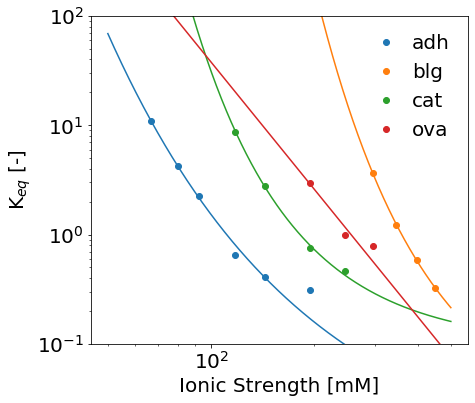

In [5]:
plot_keq('phq')

# Calculations with catalase

In [6]:
keq_fit_params, Ds_fit_params = get_correlation('phq')

fit_params = keq_fit_params[2]
tis_new = np.linspace(50, 500, 1000)
keq_new = [my_fit_function_keq(tis, fit_params[0], fit_params[1],
            fit_params[2]) for tis in tis_new]

C:\Users\Chase\Anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Chase\Anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Chase\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [7]:
def get_is_from_keq(keq, a, b, c):
    return (1.0/a * np.log(keq/c))**(1.0/b)

keq_reverse = np.logspace(-1, 2, 1000)
tis_reverse = [get_is_from_keq(keq, fit_params[0], fit_params[1],
               fit_params[2]) for keq in keq_reverse]

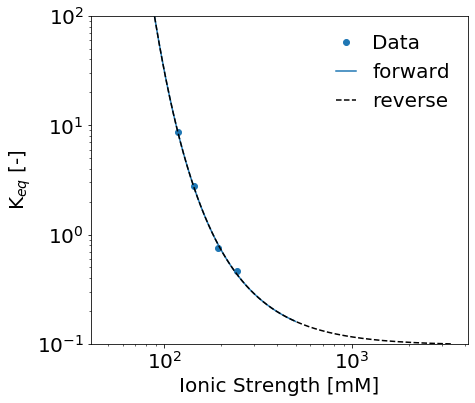

In [52]:
params = {'font.weight':'normal', 'font.size':20, 'figure.autolayout':True}
plt.rcParams.update(params)
fig, ax = plt.subplots()
fig.set_size_inches(7, 6, forward=True)
ax.set_xlabel('Ionic Strength [mM]')
ax.set_ylabel(r'K$_{eq}$ [-]')
ax.set_ylim(0.1, 100)
    
data_file, protein_list = get_fit_param_inputs()
tab_name = 'cat_phq'
df = pd.read_excel(data_file, tab_name)
df.dropna(inplace=True)

ax.loglog(df['IS (M)']*1e3, df['Keq'], 'o', label='Data')
ax.loglog(tis_new, keq_new, color=plt.gca().lines[-1].get_color(), label='forward')
ax.loglog(tis_reverse, keq_reverse, 'k--', label='reverse')

ax.legend(loc='best', frameon=False, handlelength=1.0)
fig.savefig('Keq_IS_catalase_fit.png', dpi=300)

In [50]:
df['Keq']

0    0.460590
1    0.761694
2    2.762885
3    8.764313
Name: Keq, dtype: float64

# Calculations

In [49]:
keq_desired = [100.0] # [1, 5, 10]
is_desired  = [get_is_from_keq(keq, fit_params[0], fit_params[1], fit_params[2]) for keq in keq_desired]
nacl_desired = [is_2_nacl(tis) for tis in is_desired]
percent_B = [nacl*1e-3*1e2 for nacl in nacl_desired]

v_total = 10
c_stock = 4.52
c_desired = 0.01
c_b = 1000

v_stock = c_desired / c_stock * v_total
v_b = np.array([nacl*1e-3*v_total for nacl in nacl_desired])
v_a = [v_total - v_stock - v for v in v_b]

print(f'Keq = {keq_desired[0]}')
print(f'%B = {percent_B[0]:.1f}', '\n')
print(f'V_total = {v_total} ml')
print(f'V_a = {v_a[0]:.3f} ml')
print(f'(V_a/2 = {v_a[0]/2.0:.2f} ml)')
print(f'V_b = {v_b[0]*1e3:.1f} ul')
print(f'V_protein_stock = {v_stock*1e3:.1f} ul')


Keq = 100.0
%B = 4.7 

V_total = 10 ml
V_a = 9.511 ml
(V_a/2 = 4.76 ml)
V_b = 466.8 ul
V_protein_stock = 22.1 ul


In [32]:
# Figure out how to account for dilution with tubing in Superloop/clean the superloop appropriately
cond_2_tis(12), cond_2_tis(11)

(137.3426400087, 127.4154995625)

In [6]:
is_desired  = [130]
nacl_desired = [is_2_nacl(tis) for tis in is_desired]
percent_B = [nacl*1e-3*1e2 for nacl in nacl_desired]
nacl_desired

[87.34052993130521]